# Linux Interactive System Analysis DEMO

## Get LISA and start the Notebook Server

Official repository on GitHub - ARM Software:<br>
https://github.com/ARM-software/lisa

___
Installation dependencies are listed in the main page of the repository:<br>
https://github.com/ARM-software/lisa#required-dependencies

___
Once cloned, source *init_env* to initialized the **LISA Shell**, which provides a convenient set of shell commands for easy access to many LISA related functions.

```shell
$ source init_env
```

___
To start the IPython Notebook Server required to use this Notebook, on a LISAShell run:
```shell
[LISAShell lisa] \> lisa-ipython start

Starting IPython Notebooks...
Starting IPython Notebook server...
  IP Address :  http://127.0.0.1:8888/
  Folder     :  /home/derkling/Code/lisa/ipynb
  Logfile    :  /home/derkling/Code/lisa/ipynb/server.log
  PYTHONPATH : 
	/home/derkling/Code/lisa/libs/bart
	/home/derkling/Code/lisa/libs/trappy
	/home/derkling/Code/lisa/libs/devlib
	/home/derkling/Code/lisa/libs/wlgen
	/home/derkling/Code/lisa/libs/utils
	

Notebook server task: [1] 24745


```

The main folder served by the server is:<br>
http://127.0.0.1:8888/

While the tutorial notebooks are accessible starting from this link:<br>
http://127.0.0.1:8888/notebooks/tutorial/00_LisaInANutshell.ipynb


## What is an IPython Notebook?

Let's do some example!

## Logging configuration and support modules import

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2017-07-14 11:33:47,829 INFO    : root         : Using LISA logging configuration:
2017-07-14 11:33:47,836 INFO    : root         :   /data/lisa_remote/lisa/logging.conf


In [2]:
# Execute this cell to enable verbose SSH commands
logging.getLogger().setLevel(logging.DEBUG)

In [3]:
# Other python modules required by this notebook
import json
import os

<br><br><br><br>
Advanced usage: get more confident with IPython notebooks and discover some hidden features<br>
[notebooks/tutorial/01_IPythonNotebooksUsage.ipynb](01_IPythonNotebooksUsage.ipynb)
<br><br><br><br>

# Remote target connection and control

In [4]:
# Setup a target configuration
conf = {
    
    # Target is localhost
    "platform"    : 'android',
    "board"       : "hikey960",
    
    # Login credentials
    #"host"        : "192.168.0.1",
    "username"    : "root",
    "password"    : "",

    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    "tools"   : ['rt-app', 'taskset', 'trace-cmd'],
    
    # Comment the following line to force rt-app calibration on your target
     "rtapp-calib" : {
        "0": 301, "1": 301, "2": 301, "3": 301, "4": 226, "5": 226, "6": 226, "7": 226
    },
    
    
    # FTrace events end buffer configuration
    "ftrace"  : {
        "events" : [
            "sched_switch",
            "sched_wakeup",
            "sched_wakeup_new",
            "sched_contrib_scale_f",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "sched_tune_config",
            "sched_tune_tasks_update",
            "sched_tune_boostgroup_update",
            "sched_tune_filter",
            "sched_boost_cpu",
            "sched_boost_task",
            "sched_energy_diff",
            "cpu_frequency",
            "cpu_capacity",
         ],
         "buffsize" : 10240
    },

    # Where results are collected
    "results_dir" : "LisaInANutshell_hikey960",

    # Devlib module required (or not required)
    'modules' : [ "cpufreq", "cgroups", "cpufreq" ],
    #"exclude_modules" : [ "hwmon" ],
}

In [5]:
print conf["board"]

hikey960


In [6]:
# Support to access the remote target
from env import TestEnv

# Initialize a test environment using:
# the provided target configuration (my_target_conf)
# the provided test configuration   (my_test_conf)
te = TestEnv(conf)
target = te.target

print "DONE"

2017-07-14 11:33:53,626 WARNING : EnergyModel  : Unusual max capacity (1023), overriding capacity_scale
2017-07-14 11:33:53,635 INFO    : TestEnv      : Using base path: /data/lisa_remote/lisa
2017-07-14 11:33:53,642 INFO    : TestEnv      : Loading custom (inline) target configuration
2017-07-14 11:33:53,643 INFO    : TestEnv      : External tools using:
2017-07-14 11:33:53,646 INFO    : TestEnv      :    ANDROID_HOME: /home/zhifei/zyang/android-sdk-linux
2017-07-14 11:33:53,648 INFO    : TestEnv      :    CATAPULT_HOME: /data/lisa_remote/lisa/tools/catapult
2017-07-14 11:33:53,651 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq', 'cgroups']
2017-07-14 11:33:53,654 INFO    : TestEnv      : Connecting Android target [DEFAULT]
2017-07-14 11:33:53,656 INFO    : TestEnv      : Connection settings:
2017-07-14 11:33:53,662 INFO    : TestEnv      :    None
2017-07-14 11:33:54,477 INFO    : TestEnv      : Initializing target workdir:
2017-07-14 11:33:54,484 INFO   

DONE


## Commands execution on remote target

In [7]:
# Enable Energy-Aware scheduler
target.execute("echo ENERGY_AWARE > /sys/kernel/debug/sched_features");

# Check which sched_feature are enabled
sched_features = target.read_value("/sys/kernel/debug/sched_features");
print "sched_features:"
print sched_features

TargetError: Got exit code 1
from target command: echo ENERGY_AWARE > /sys/kernel/debug/sched_features
STDOUT: 
STDERR: /system/bin/sh: can't create /sys/kernel/debug/sched_features: Permission denied


In [8]:
# It's possible also to run custom script
# my_script = target.get_installed()
# target.execute(my_script)

## Example of frameworks configuration on remote target

### Configure CPUFreq governor to be "sched-freq"

In [9]:
target.cpufreq.set_all_governors('sched');

# Check which governor is enabled on each CPU
enabled_governors =  target.cpufreq.get_all_governors()
print enabled_governors

{'1': 'sched', '0': 'sched', '3': 'sched', '2': 'sched', '5': 'sched', '4': 'sched', '7': 'sched', '6': 'sched'}


### Create a big/LITTLE partition using CGroups::CPUSet

In [10]:
cpuset = target.cgroups.controller('cpuset')

# Configure a big partition
cpuset_bigs = cpuset.cgroup('/big')

print cpuset_bigs

cpuset_bigs.set(cpus=te.target.bl.bigs, mems=0)

print "cpuset_bigs is created"

# Configure a LITTLE partition
cpuset_littles = cpuset.cgroup('/LITTLE')
cpuset_littles.set(cpus=te.target.bl.littles, mems=0)

print "cpuset_littles is created"

# Dump the configuraiton of each controller
cgroups = cpuset.list_all()
for cgname in cgroups:
    cgroup = cpuset.cgroup(cgname)
    attrs = cgroup.get()
    cpus = attrs['cpus']
    print '{}:{:<15} cpus: {}'.format(cpuset.kind, cgroup.name, cpus)

2017-07-14 11:34:23,927 DEBUG   : cgroups.cpuset : Creating cgroup /data/local/tmp/devlib-target/cgroups/devlib_cgh5/big
2017-07-14 11:34:24,017 DEBUG   : cgroups.cpuset : Set attribute [/data/local/tmp/devlib-target/cgroups/devlib_cgh5/big/cpus] to: 4-7"
2017-07-14 11:34:24,178 DEBUG   : cgroups.cpuset : Set attribute [/data/local/tmp/devlib-target/cgroups/devlib_cgh5/big/mems] to: 0"


2017-07-14 11:34:24,318 DEBUG   : cgroups.cpuset : Creating cgroup /data/local/tmp/devlib-target/cgroups/devlib_cgh5/LITTLE
2017-07-14 11:34:24,396 DEBUG   : cgroups.cpuset : Set attribute [/data/local/tmp/devlib-target/cgroups/devlib_cgh5/LITTLE/cpus] to: 0-3"


cpuset_bigs is created


2017-07-14 11:34:24,534 DEBUG   : cgroups.cpuset : Set attribute [/data/local/tmp/devlib-target/cgroups/devlib_cgh5/LITTLE/mems] to: 0"
2017-07-14 11:34:24,674 DEBUG   : CGroup.cpuset : Listing groups for cpuset controller
2017-07-14 11:34:24,741 DEBUG   : CGroup.cpuset : Populate cpuset cgroup: /
2017-07-14 11:34:24,743 DEBUG   : CGroup.cpuset : Populate cpuset cgroup: /big
2017-07-14 11:34:24,745 DEBUG   : CGroup.cpuset : Populate cpuset cgroup: /LITTLE
2017-07-14 11:34:24,748 DEBUG   : CGroup.cpuset : Populate cpuset cgroup: /system-background
2017-07-14 11:34:24,749 DEBUG   : CGroup.cpuset : Populate cpuset cgroup: /background
2017-07-14 11:34:24,750 DEBUG   : CGroup.cpuset : Populate cpuset cgroup: /foreground
2017-07-14 11:34:24,752 DEBUG   : CGroup.cpuset : Populate cpuset cgroup: /foreground/boost
2017-07-14 11:34:24,753 DEBUG   : CGroup.cpuset : Populate cpuset cgroup: /top-app
2017-07-14 11:34:24,756 DEBUG   : root         : Reading cpuset attributes from:
2017-07-14 11:34:24

cpuset_littles is created
cpuset:/               cpus: 0-7


2017-07-14 11:34:25,022 DEBUG   : root         : Reading cpuset attributes from:
2017-07-14 11:34:25,023 DEBUG   : root         :   /data/local/tmp/devlib-target/cgroups/devlib_cgh5/LITTLE
2017-07-14 11:34:25,129 DEBUG   : cgroups.cpuset : Creating cgroup /data/local/tmp/devlib-target/cgroups/devlib_cgh5/system-background
2017-07-14 11:34:25,201 DEBUG   : root         : Reading cpuset attributes from:
2017-07-14 11:34:25,203 DEBUG   : root         :   /data/local/tmp/devlib-target/cgroups/devlib_cgh5/system-background


cpuset:/big            cpus: 4-7
cpuset:/LITTLE         cpus: 0-3


2017-07-14 11:34:25,320 DEBUG   : cgroups.cpuset : Creating cgroup /data/local/tmp/devlib-target/cgroups/devlib_cgh5/background
2017-07-14 11:34:25,387 DEBUG   : root         : Reading cpuset attributes from:
2017-07-14 11:34:25,389 DEBUG   : root         :   /data/local/tmp/devlib-target/cgroups/devlib_cgh5/background
2017-07-14 11:34:25,486 DEBUG   : cgroups.cpuset : Creating cgroup /data/local/tmp/devlib-target/cgroups/devlib_cgh5/foreground


cpuset:/system-background cpus: 0-3
cpuset:/background     cpus: 0


2017-07-14 11:34:25,549 DEBUG   : root         : Reading cpuset attributes from:
2017-07-14 11:34:25,550 DEBUG   : root         :   /data/local/tmp/devlib-target/cgroups/devlib_cgh5/foreground
2017-07-14 11:34:25,658 DEBUG   : cgroups.cpuset : Creating cgroup /data/local/tmp/devlib-target/cgroups/devlib_cgh5/foreground/boost
2017-07-14 11:34:25,728 DEBUG   : root         : Reading cpuset attributes from:
2017-07-14 11:34:25,731 DEBUG   : root         :   /data/local/tmp/devlib-target/cgroups/devlib_cgh5/foreground/boost
2017-07-14 11:34:25,827 DEBUG   : cgroups.cpuset : Creating cgroup /data/local/tmp/devlib-target/cgroups/devlib_cgh5/top-app


cpuset:/foreground     cpus: 0-6
cpuset:/foreground/boost cpus: 0


2017-07-14 11:34:25,891 DEBUG   : root         : Reading cpuset attributes from:
2017-07-14 11:34:25,893 DEBUG   : root         :   /data/local/tmp/devlib-target/cgroups/devlib_cgh5/top-app


cpuset:/top-app        cpus: 0-7


<br><br><br><br>
Advanced usage: exploring more APIs exposed by TestEnv and Devlib<br>
[notebooks/tutorial/02_TestEnvUsage.ipynb](02_TestEnvUsage.ipynb)
<br><br><br><br>

# Using syntethic workloads

## Generate an RTApp configuration

In [11]:
# RTApp configurator for generation of PERIODIC tasks
from wlgen import RTA, Periodic, Ramp

# Light workload
light  = Periodic(
            duty_cycle_pct = 10,
            duration_s     =  3,
            period_ms      = 32,
)

# Ramp workload
ramp   = Ramp(
            start_pct=10,
            end_pct=60,
            delta_pct=20,
            time_s=0.5,
            period_ms=16
)

# Heavy workload
heavy  = Periodic(
            duty_cycle_pct=60,
            duration_s=3,
            period_ms=16
)

# Composed workload
lrh_task = light + ramp + heavy


# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'test', calibration=te.calibration())


# Configure this RTApp instance to:
rtapp.conf(

    # 1. generate a "profile based" set of tasks
    kind = 'profile',
    
    # 2. define the "profile" of each task
    params = {
        
        # 3. Composed task
        'task_lrh': lrh_task.get(),
    },
    
    #loadref='big',
    loadref='LITTLE',
    run_dir=target.working_directory
    
);

2017-07-14 11:34:34,459 INFO    : Workload     : Setup new workload test
2017-07-14 11:34:34,540 INFO    : Workload     : Workload duration defined by longest task
2017-07-14 11:34:34,542 INFO    : Workload     : Default policy: SCHED_OTHER
2017-07-14 11:34:34,543 INFO    : Workload     : ------------------------
2017-07-14 11:34:34,545 INFO    : Workload     : task [task_lrh], sched: using default policy
2017-07-14 11:34:34,546 INFO    : Workload     :  | calibration CPU: 0
2017-07-14 11:34:34,547 INFO    : Workload     :  | loops count: 1
2017-07-14 11:34:34,548 INFO    : Workload     : + phase_000001: duration 3.000000 [s] (93 loops)
2017-07-14 11:34:34,552 INFO    : Workload     : |  period    32000 [us], duty_cycle  10 %
2017-07-14 11:34:34,553 INFO    : Workload     : |  run_time   3200 [us], sleep_time  28800 [us]
2017-07-14 11:34:34,560 INFO    : Workload     : + phase_000002: duration 0.500000 [s] (31 loops)
2017-07-14 11:34:34,562 INFO    : Workload     : |  period    16000 [

In [12]:
# Inspect the JSON file used to run the application
with open('./test_00.json', 'r') as fh:
    rtapp_json = json.load(fh)
logging.info('Generated RTApp JSON file:')
print json.dumps(rtapp_json, indent=4, sort_keys=True)

2017-07-14 11:34:38,784 INFO    : root         : Generated RTApp JSON file:


{
    "global": {
        "calibration": 301, 
        "default_policy": "SCHED_OTHER", 
        "duration": -1, 
        "logdir": "/data/local/tmp/devlib-target"
    }, 
    "tasks": {
        "task_lrh": {
            "loop": 1, 
            "phases": {
                "p000001": {
                    "loop": 93, 
                    "run": 3200, 
                    "timer": {
                        "period": 32000, 
                        "ref": "task_lrh"
                    }
                }, 
                "p000002": {
                    "loop": 31, 
                    "run": 1600, 
                    "timer": {
                        "period": 16000, 
                        "ref": "task_lrh"
                    }
                }, 
                "p000003": {
                    "loop": 31, 
                    "run": 4800, 
                    "timer": {
                        "period": 16000, 
                        "ref": "task_lrh"
                    }
    

<br><br><br><br>
Advanced usage: using WlGen to create more complex RTApp configurations or run other banchmarks (e.g. hackbench)<br>
[notebooks/tutorial/03_WlGenUsage.ipynb](03_WlGenUsage.ipynb)
<br><br><br><br>

## Execution and Energy Sampling

In [13]:
#
# if hikey960 board has AEP or ACME, set below variable to 1
#
hikey960_has_energy_meter = 0

def execute(te, wload, res_dir):
    
    logging.info('# Setup FTrace')
    te.ftrace.start()

    if hikey960_has_energy_meter:
        logging.info('## Start energy sampling')
        te.emeter.reset()

    logging.info('### Start RTApp execution')
    wload.run(out_dir=res_dir)

    if hikey960_has_energy_meter:
        logging.info('## Read energy consumption: %s/energy.json', res_dir)
        nrg_report = te.emeter.report(out_dir=res_dir)
    else:
        nrg_report = None

    logging.info('# Stop FTrace')
    te.ftrace.stop()

    trace_file = os.path.join(res_dir, 'trace.dat')
    logging.info('# Save FTrace: %s', trace_file)
    te.ftrace.get_trace(trace_file)

    logging.info('# Save platform description: %s/platform.json', res_dir)
    plt, plt_file = te.platform_dump(res_dir)
    
    logging.info('# Report collected data:')
    logging.info('   %s', res_dir)
    !tree {res_dir}
    
    return nrg_report, plt, plt_file, trace_file

In [14]:
nrg_report, plt, plt_file, trace_file = execute(te, rtapp, te.res_dir)

2017-07-14 11:34:45,991 INFO    : root         : # Setup FTrace
2017-07-14 11:34:48,418 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2017-07-14 11:34:48,507 DEBUG   : FtraceCollector : Trace CPUIdle states
2017-07-14 11:34:48,635 INFO    : root         : ### Start RTApp execution
2017-07-14 11:34:48,636 INFO    : Workload     : Workload execution START:
2017-07-14 11:34:48,637 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/test_00.json 2>&1


2017-07-14 11:34:56,415 INFO    : root         : # Stop FTrace
2017-07-14 11:34:56,417 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2017-07-14 11:34:56,709 INFO    : root         : # Save FTrace: /data/lisa_remote/lisa/results/LisaInANutshell_hikey960/trace.dat
2017-07-14 11:34:58,674 INFO    : root         : # Save platform description: /data/lisa_remote/lisa/results/LisaInANutshell_hikey960/platform.json
2017-07-14 11:34:58,676 INFO    : root         : # Report collected data:
2017-07-14 11:34:58,677 INFO    : root         :    /data/lisa_remote/lisa/results/LisaInANutshell_hikey960


/data/lisa_remote/lisa/results/LisaInANutshell_hikey960
├── output.log
├── platform.json
├── rt-app-task_lrh-0.log
├── test_00.json
└── trace.dat

0 directories, 5 files


## Example of energy collected data

In [15]:
import pandas as pd

if hikey960_has_energy_meter:
    df = pd.DataFrame(list(nrg_report.channels.iteritems()),
                  columns=['Cluster', 'Energy'])
    df = df.set_index('Cluster')
    df

## Example of platform description

In [16]:
# Show the collected platform description
with open(os.path.join(te.res_dir, 'platform.json'), 'r') as fh:
    platform = json.load(fh)
print json.dumps(platform, indent=4)
logging.info('LITTLE cluster max capacity: %d',
             platform['nrg_model']['little']['cpu']['cap_max'])

2017-07-14 11:35:03,874 INFO    : root         : LITTLE cluster max capacity: 870


{
    "kernel": {
        "major": 4, 
        "sha1": "679a543", 
        "version": "2507 SMP PREEMPT Tue Apr 11 09:52:10 PDT 2017", 
        "version_number": 4, 
        "parts": [
            4, 
            4, 
            59
        ], 
        "rc": null, 
        "release": "4.4.59-02536-g679a543", 
        "minor": 59
    }, 
    "abi": "arm64", 
    "freqs": {
        "big": [
            903000, 
            1421000, 
            1805000, 
            2112000, 
            2362000
        ], 
        "little": [
            533000, 
            999000, 
            1402000, 
            1709000, 
            1844000
        ]
    }, 
    "nrg_model": {
        "big": {
            "cluster": {
                "nrg_max": 118
            }, 
            "cpu": {
                "cap_max": 1024, 
                "nrg_max": 1715
            }
        }, 
        "little": {
            "cluster": {
                "nrg_max": 70
            }, 
            "cpu": {
             

<br><br><br><br>
Advanced Workload Execution: using the Executor module to automate data collection for multiple tests<br>
[notebooks/tutorial/04_ExecutorUsage.ipynb](04_ExecutorUsage.ipynb)
<br><br><br><br>

# Trace Visualization (the kernelshark way)

## Using kernelshark

In [17]:
# Let's look at the trace using kernelshark...
trace_file = te.res_dir + '/trace.dat'
!kernelshark {trace_file} 2>/dev/null

version = 6


## Using the TRAPpy Trace Plotter

In [18]:
# Suport for FTrace events parsing and visualization
import trappy

# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(trace_file)

# Example of Trace Analysis

## Generate DataFrames from Trace Events

In [19]:
# Load the LISA::Trace parsing module
from trace import Trace

# Define which event we are interested into
trace = Trace(te.platform, te.res_dir, [
            "sched_switch",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "sched_boost_cpu",
            "sched_boost_task",
            "cpu_frequency",
            "cpu_capacity",
    ])

2017-07-14 11:35:20,626 DEBUG   : Trace        : Loading [sched] events from trace in [/data/lisa_remote/lisa/results/LisaInANutshell_hikey960]...
2017-07-14 11:35:20,630 DEBUG   : Trace        : Parsing events: ['sched_switch', 'sched_load_avg_cpu', 'sched_load_avg_task', 'sched_boost_cpu', 'sched_boost_task', 'cpu_frequency', 'cpu_capacity', 'cpu_frequency_devlib']
2017-07-14 11:35:20,633 DEBUG   : Trace        : Parsing FTrace format...
2017-07-14 11:35:21,766 DEBUG   : Trace        : Events found on trace:
2017-07-14 11:35:21,773 DEBUG   : Trace        :  - sched_load_avg_task
2017-07-14 11:35:21,778 DEBUG   : Trace        :  - cpu_frequency
2017-07-14 11:35:21,779 DEBUG   : Trace        :  - cpu_capacity
2017-07-14 11:35:21,780 DEBUG   : Trace        :  - sched_load_avg_cpu
2017-07-14 11:35:21,784 DEBUG   : Trace        :  - sched_boost_cpu
2017-07-14 11:35:21,785 DEBUG   : Trace        :  - cpu_frequency_devlib
2017-07-14 11:35:21,786 DEBUG   : Trace        :  - sched_boost_task


In [22]:
# Let's have a look at the set of events collected from the trace
ftrace = trace.ftrace
logging.info("List of events identified in the trace:")
for event in ftrace.class_definitions.keys():
    logging.info("   %s", event)

2017-07-14 11:22:04,005 INFO    : root         : List of events identified in the trace:
2017-07-14 11:22:04,009 INFO    : root         :    sched_load_avg_task
2017-07-14 11:22:04,010 INFO    : root         :    cpu_frequency
2017-07-14 11:22:04,016 INFO    : root         :    tracing_mark_write
2017-07-14 11:22:04,017 INFO    : root         :    cpu_capacity
2017-07-14 11:22:04,019 INFO    : root         :    cpu_idle
2017-07-14 11:22:04,020 INFO    : root         :    sched_load_avg_cpu
2017-07-14 11:22:04,021 INFO    : root         :    sched_boost_cpu
2017-07-14 11:22:04,028 INFO    : root         :    cpu_frequency_devlib
2017-07-14 11:22:04,029 INFO    : root         :    sched_boost_task
2017-07-14 11:22:04,030 INFO    : root         :    sched_switch


In [23]:
# Trace events are converted into tables, let's have a look at one
# of such tables
df = trace.data_frame.trace_event('sched_load_avg_task')
df.head()

,__comm,__cpu,__line,__pid,comm,cpu,load_avg,load_sum,period_contrib,pid,util_avg,util_sum,cluster,min_cluster_cap
Time,,,,,,,,,,,,,,
0.000340,trace-cmd,3,22,9011,trace-cmd,3,160,7656614,403,9011,40,1951243,LITTLE,870
0.000340,<idle>,1,23,0,sh,1,0,0,970,9009,0,0,LITTLE,870
0.000347,trace-cmd,3,32,9011,shell srvc 9007,3,0,140288,470,9010,0,0,LITTLE,870
0.000445,shell,3,44,9010,shell srvc 9007,3,0,182272,563,9010,0,10701,LITTLE,870
0.000447,shell,3,46,9010,adbd,3,0,0,299,2044,0,0,LITTLE,870


In [24]:
# Simple selection of events based on conditional values
#df[df.comm == 'task_lrh'].head()

# Simple selection of specific signals
#df[df.comm == 'task_lrh'][['util_avg']].head()

# Simple statistics reporting
#df[df.comm == 'task_lrh'][['util_avg']].describe()

<br><br><br><br>
Advanced DataFrame usage: filtering by columns/rows, merging tables, plotting data<br>
[notebooks/tutorial/05_TrappyUsage.ipynb](05_TrappyUsage.ipynb)
<br><br><br><br>

## Easy plot signals from DataFrams

In [25]:
# Signals can be easily plot using the ILinePlotter
trappy.ILinePlot(
    
    # FTrace object
    ftrace,
    
    # Signals to be plotted
    signals=[
      'sched_load_avg_cpu:util_avg',
      'sched_load_avg_task:util_avg'
    ],
    
#     # Generate one plot for each value of the specified column
#      pivot='cpu',
    
#     # Generate only plots which satisfy these filters
#     filters={
#         'comm': ['task_lrh'],
#         'cpu' : [0,5]
#     },
    
    # Formatting style
    per_line=2,
    drawstyle='steps-post',
    marker = '+'

).view()

""
""


# Example of Behavioral Analysis

In [26]:
from bart.sched.SchedMultiAssert import SchedAssert

# Create an object to get/assert scheduling pbehaviors
sa = SchedAssert(ftrace, te.topology,  execname='task_lrh')

## Get tasks behaviors

In [27]:
# Check the residency of a task on the LITTLE cluster
print "Task residency [%] on LITTLE cluster:",\
sa.getResidency(
    "cluster",
    te.target.bl.littles,
    percent=True
)

Task residency [%] on LITTLE cluster: 45.4682628865


In [28]:
# Check on which CPU the task start its execution
print "Task initial CPU:",\
sa.getFirstCpu()

Task initial CPU: 2


## Check for expected behaviros

In [29]:
import operator

# Define the time window where we want focus our assertions
start_s = sa.getStartTime()
little_residency_window = (start_s, start_s + 10)

# Defined the expected task residency 
EXPECTED_RESIDENCY_PCT=99

result = sa.assertResidency(
    "cluster",
    te.target.bl.littles,
    EXPECTED_RESIDENCY_PCT,
    operator.ge,
    window=little_residency_window,
    percent=True
)
print "Task running {} [%] of its time on LITTLE? {}"\
      .format(EXPECTED_RESIDENCY_PCT, result)

Task running 99 [%] of its time on LITTLE? False


In [30]:
result = sa.assertFirstCpu(te.target.bl.bigs)
print "Task starting on a big CPU? {}".format(result)

Task starting on a big CPU? False


# Examples of Data analysis

## Which task is the most active switcher?

In [31]:
# Focus on sched_switch events
df = ftrace.sched_switch.data_frame

# # Select only interesting columns
# df = df.ix[:,'next_comm':'prev_state']

# # Group sched_switch event by task switching into the CPU
# df = df.groupby('next_pid').describe(include=['object'])
# df = df.unstack()

# # Sort sched_switch events by number of time a task switch into the CPU
# df = df['next_comm'].sort_values(by=['count'], ascending=False)

df.head()

# # Get topmost task name and PID
# most_switching_pid  = df.index[1]
# most_switching_task = df.values[1][2]
# task_name = "{}:{}".format(most_switching_pid, most_switching_task)

# # Print result
# logging.info("The most swithing task is: [%s]", task_name)

,__comm,__cpu,__line,__pid,next_comm,next_pid,next_prio,prev_comm,prev_pid,prev_prio,prev_state
Time,,,,,,,,,,,
0.000343,<idle>,1,28,0,sh,9009,120,swapper/1,0,120,0
0.000350,trace-cmd,3,34,9011,shell srvc 9007,9010,120,trace-cmd,9011,120,64
0.000449,shell,3,48,9010,adbd,2044,120,shell srvc 9007,9010,120,2048
0.000680,adbd,3,66,2044,->transport,2078,120,adbd,2044,120,1
0.000741,->transport,3,77,2078,shell srvc 9007,9010,120,->transport,2078,120,1


## What are the relative residency on different OPPs?

In [32]:
# Focus on cpu_frequency events for CPU0
df = ftrace.cpu_frequency.data_frame
df = df[df.cpu == 0]

# # Compute the residency on each OPP before switching to the next one
# df.loc[:,'start'] = df.index
# df.loc[:,'delta'] = (df['start'] - df['start'].shift()).fillna(0).shift(-1)

# # Group by frequency and sum-up the deltas
# freq_residencies = df.groupby('frequency')['delta'].sum()
# logging.info("Residency time per OPP:")
# df = pd.DataFrame(freq_residencies)

df.head()

# # Compute the relative residency time
# tot = sum(freq_residencies)
# #df = df.apply(lambda delta : 100*delta/tot)
# for f in freq_residencies.index:
#     logging.info("Freq %10dHz : %5.1f%%", f, 100*freq_residencies[f]/tot)

,__comm,__cpu,__line,__pid,cpu,frequency
Time,,,,,,
0.056862,kschedfreq:0,2,1396,8830,0,999000
0.107130,kschedfreq:0,2,2662,8830,0,533000
0.116262,kschedfreq:0,2,2914,8830,0,999000
0.167567,kschedfreq:0,2,4754,8830,0,533000
0.212129,kschedfreq:0,2,5744,8830,0,999000


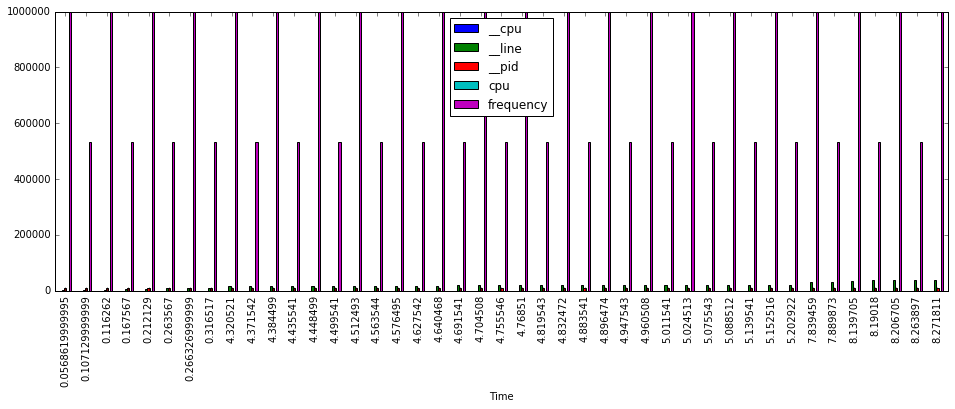

In [33]:
# Plot residency time
import matplotlib.pyplot as plt
# Enable generation of Notebook emebedded plots
%matplotlib inline

fig, axes = plt.subplots(1, 1, figsize=(16, 5));
df.plot(kind='bar', ax=axes);

# Example of Custom Plotting

In [34]:
from perf_analysis import PerfAnalysis

# Full analysis function
def analysis(t_min=None, t_max=None):
    test_dir = te.res_dir
    platform_json = '{}/platform.json'.format(test_dir)
    trace_file = '{}/trace.dat'.format(test_dir)
    
    # Load platform description data
    with open(platform_json, 'r') as fh:
        platform = json.load(fh)

    # Load RTApp Performance data
    pa = PerfAnalysis(test_dir)
    logging.info("Loaded performance data for tasks: %s", pa.tasks())
    
    # Load Trace data
    #events = my_tests_conf['ftrace']['events']
    events = [
            "sched_switch",
            "sched_contrib_scale_f",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "cpu_frequency",
            "cpu_capacity",
    ]
    trace = Trace(platform, test_dir, events, tasks=pa.tasks())
    
    # Define time ranges for all the temporal plots
    trace.setXTimeRange(t_min, t_max)
    
    # Tasks performances plots
    for task in pa.tasks():
        pa.plotPerf(task)
    
    # Tasks plots
    trace.analysis.tasks.plotTasks()

    # Cluster and CPUs plots
    trace.analysis.frequency.plotClusterFrequencies()

2017-07-14 11:23:04,695 DEBUG   : PerfAnalysis : Found rt-app logfile for task [task_lrh]
2017-07-14 11:23:04,704 DEBUG   : PerfAnalysis : Loading dataframe for task [task_lrh]...
2017-07-14 11:23:04,721 INFO    : root         : Loaded performance data for tasks: ['task_lrh']
2017-07-14 11:23:04,724 DEBUG   : Trace        : Loading [sched] events from trace in [/data/lisa_remote/lisa/results/LisaInANutshell_hikey]...
2017-07-14 11:23:04,732 DEBUG   : Trace        : Parsing events: ['sched_switch', 'sched_contrib_scale_f', 'sched_load_avg_cpu', 'sched_load_avg_task', 'cpu_frequency', 'cpu_capacity', 'cpu_frequency_devlib']
2017-07-14 11:23:04,734 DEBUG   : Trace        : Parsing FTrace format...
2017-07-14 11:23:05,796 DEBUG   : Trace        : Events found on trace:
2017-07-14 11:23:05,801 DEBUG   : Trace        :  - sched_load_avg_task
2017-07-14 11:23:05,804 DEBUG   : Trace        :  - cpu_frequency
2017-07-14 11:23:05,808 DEBUG   : Trace        :  - cpu_capacity
2017-07-14 11:23:05,8

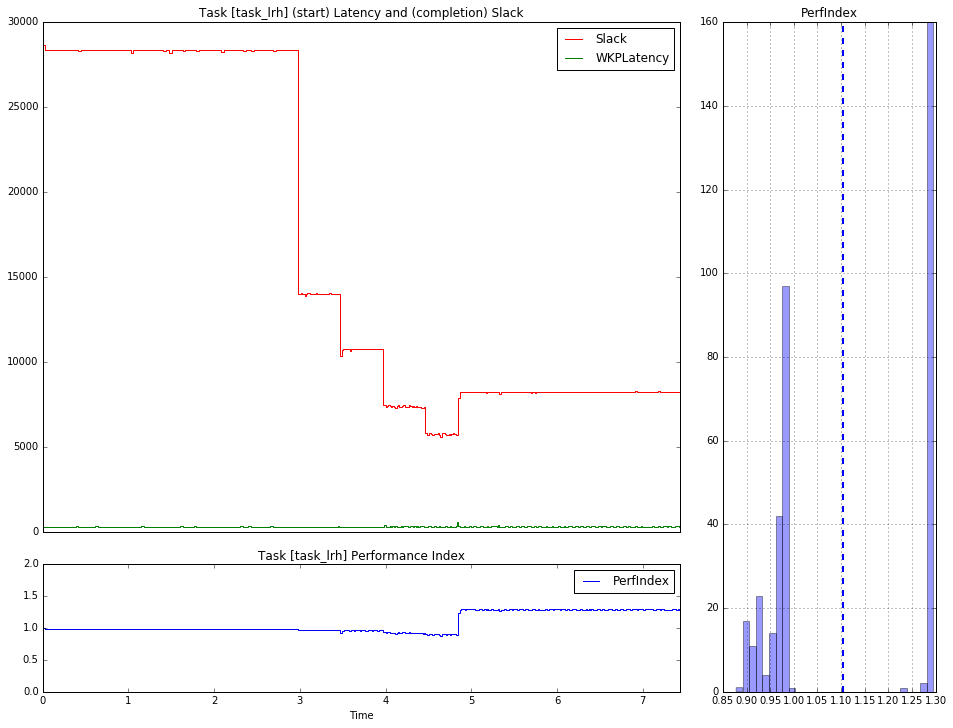

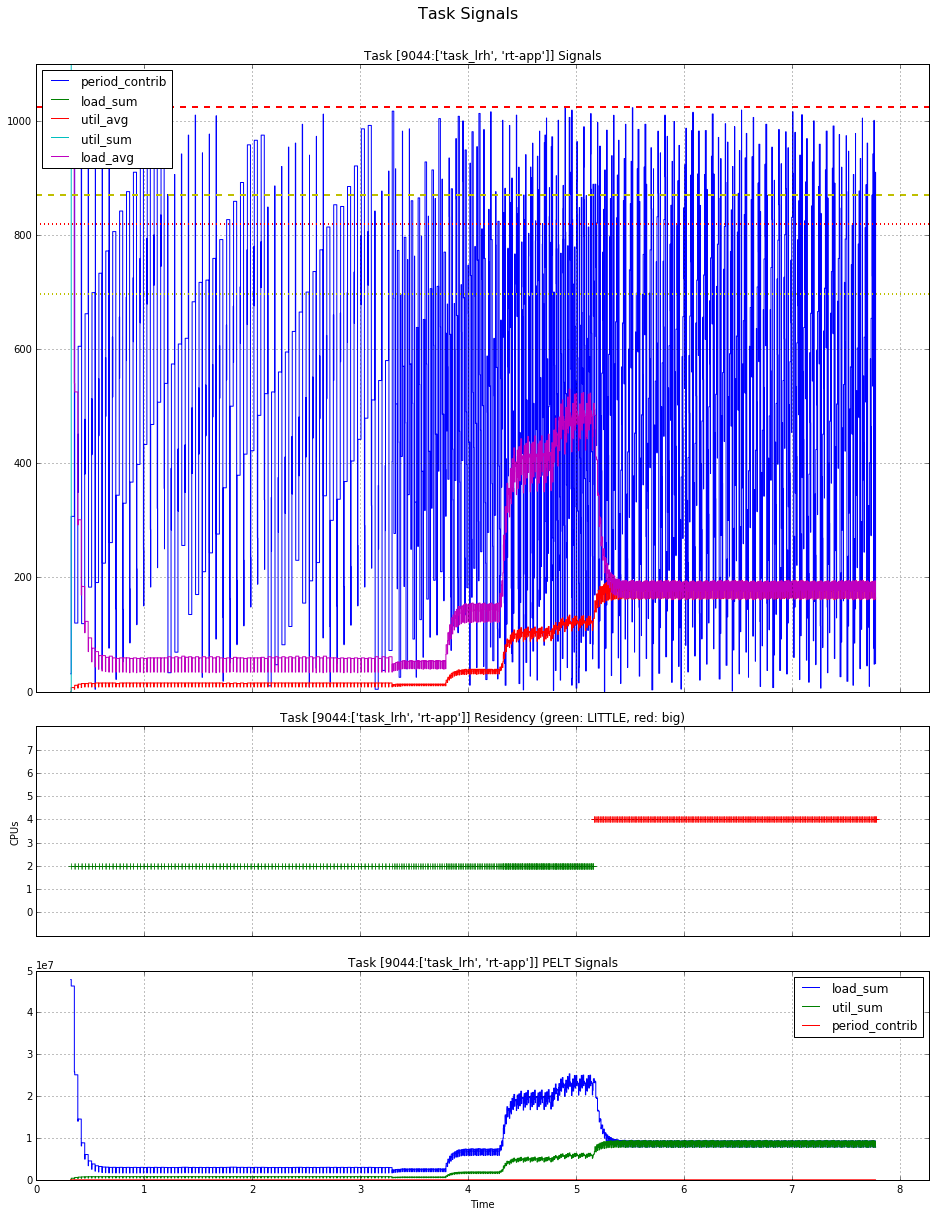

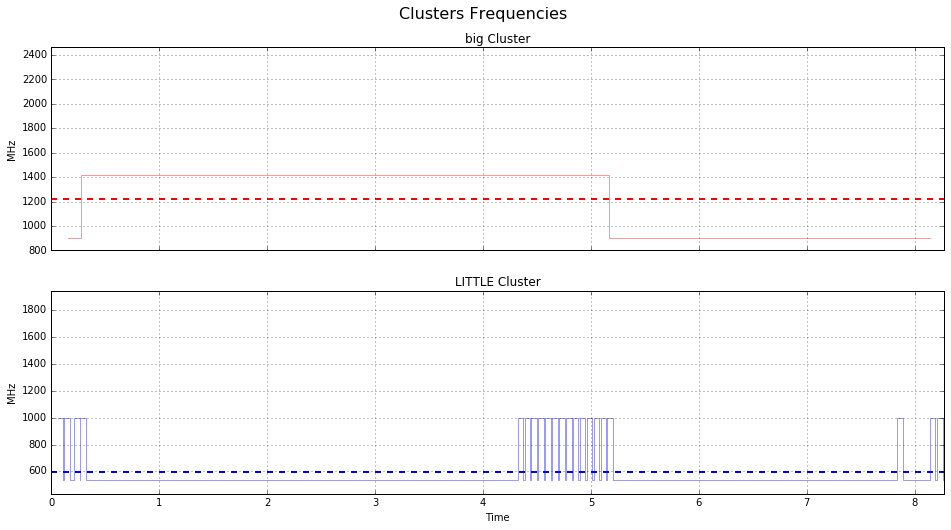

In [35]:
analysis()

<br><br><br><br>
Advanced TraceAnalysis and PerfAnalysis usage: use pre-defined functions to plot trace data and RTApp performance metrics<br>
[notebooks/tutorial/06_TraceAnalysis.ipynb](06_TraceAnalysis.ipynb)
<br>
[notebooks/tutorial/07_PerfAnalysis.ipynb](07_PerfAnalysis.ipynb)
<br><br><br><br>